In [207]:
import numpy as np
import SpringRank_tools as sr
import json
import networkx as nx
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['figure.figsize'] = [6, 10]

In [2]:
class Game:
    def __init__(self, winner, loser, rnd = -1):
        self.winner = winner
        self.loser = loser
        self.round = rnd
        
data = np.loadtxt('./2019Box.csv',
                  dtype={'names': ('date', 'team', 'place', 'opponent', 'score'),
                         'formats': ('U20', 'U20', 'U5', 'U20', 'i4')},
                 delimiter = ',')

with open('2019.json') as f:
    mm_data = json.load(f)

In [3]:
games = []
for i in range(int(len(data) / 2)):
    away = data[2 * i]
    home = data[2 * i + 1]
    if home['score'] > away['score']:
        games.append(Game(home['team'], away['team']))
    else:
        games.append(Game(away['team'], home['team']))
        
mm_games = []

for reg in range(4):
    for rnd in range(4):
        for g_num in range(2**(3 - rnd)):
            if mm_data['regions'][reg][rnd][g_num][0]['score'] > \
            mm_data['regions'][reg][rnd][g_num][1]['score']:
                mm_games.append(Game(mm_data['regions'][reg][rnd][g_num][0]['team'],
                                    mm_data['regions'][reg][rnd][g_num][1]['team'],
                                    mm_data['regions'][reg][rnd][g_num][0]['round_of']))
            else:
                mm_games.append(Game(mm_data['regions'][reg][rnd][g_num][1]['team'],
                                    mm_data['regions'][reg][rnd][g_num][0]['team'],
                                    mm_data['regions'][reg][rnd][g_num][0]['round_of']))
                
for rnd in range(2):
    for g_num in range(2**(1 - rnd)):
        if mm_data['finalfour'][rnd][g_num][0]['score'] > \
        mm_data['finalfour'][rnd][g_num][1]['score']:
            mm_games.append(Game(mm_data['finalfour'][rnd][g_num][0]['team'],
                                mm_data['finalfour'][rnd][g_num][1]['team'],
                                mm_data['finalfour'][rnd][g_num][0]['round_of']))
        else:
            mm_games.append(Game(mm_data['finalfour'][rnd][g_num][1]['team'],
                                mm_data['finalfour'][rnd][g_num][0]['team'],
                                mm_data['finalfour'][rnd][g_num][0]['round_of']))
        
teams = list(set(data['team']))
teams.sort()

team_dict = {}
count = 0
for t in teams:
    team_dict[t] = count
    count += 1

In [4]:
adj_mat = np.zeros((len(teams), len(teams)))

for g in games:
    adj_mat[team_dict[g.winner], team_dict[g.loser]] += 1

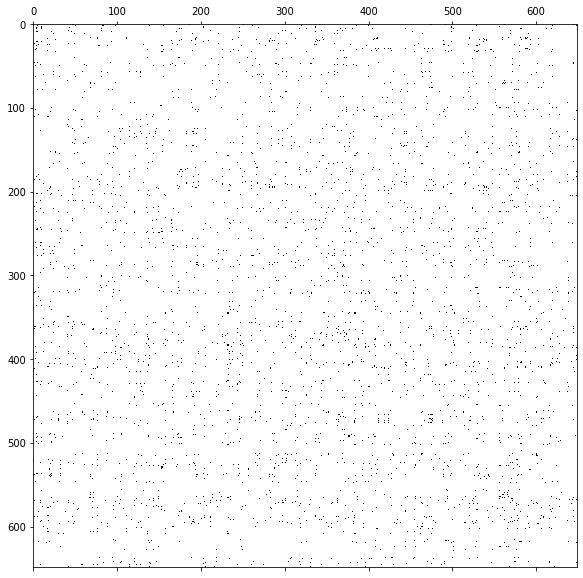

In [5]:
plt.spy(adj_mat)
plt.show()

In [6]:
rank = sr.SpringRank(adj_mat) # Compute spring rank
rank = np.argsort(-rank) # Sorts to give the index of that ranking

In [7]:
print(teams[rank[0]]) # Duke first overall seed
print(teams[rank[1]]) # Virginia second overall seed
print(teams[rank[-1]]) # Cairn lowest overall seed (division 3)

Duke
Virginia
St. Elizabeth


In [8]:
rank_dict = {}
for i in range(len(teams)):
    rank_dict[teams[rank[i]]] = i

In [9]:
rank_dict['Montana'] # spring rank of a given team

115

In [10]:
count = 0
for g in mm_games:
    if g.round == 2:
        if rank_dict[g.winner] < rank_dict[g.loser]:
            count += 1
        
print(count)

1


In [11]:
print(rank_dict['Auburn'])
print(rank_dict['Kansas'])

17
6


In [210]:
N = 649
G = nx.convert_matrix.from_numpy_matrix(adj_mat[:N,:N], create_using=nx.DiGraph())

In [213]:
labels = {}
for i in range(N):
    labels[i] = teams[i]
    
for u, v, data in G.edges(data = True):
    if rank_dict[teams[u]] > rank_dict[teams[v]]:
        G[u][v]['colour'] = 'red'
    else:
        G[u][v]['colour'] = 'green'
edge_colours = [G[u][v]['colour'] for u, v in G.edges()]

colour = {1: 'black', 2: 'purple', 4: 'blue', 8: 'cyan', 16: 'green', 32: 'yellow', 64: 'orange', -1: 'red'}
node_colours = []

for i in list(G.nodes()):
    rnd = -1
    for g in mm_games:
        if g.loser == teams[i]:
            rnd = g.round
    if teams[i] == 'Virginia':
        rnd = 1
    node_colours.append(colour[rnd])

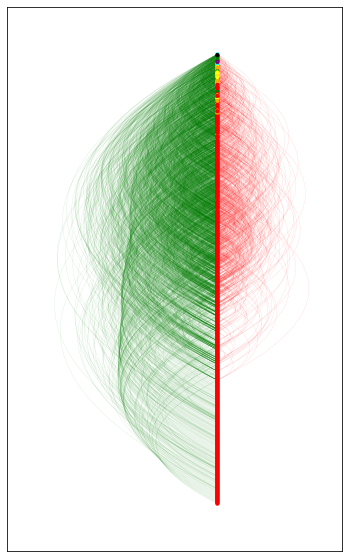

In [215]:
pos = {}
for i in range(N):
    pos[i] = [0, -rank_dict[teams[i]]]
    
nx.draw_networkx(G, pos = pos, with_labels = False, edge_color = edge_colours,
                node_color = node_colours, node_size = 10, width= 0.05,
                connectionstyle = 'arc3, rad=1', arrowstyle = '-')

#plt.savefig('Heirarchy.pdf', bbox_inches='tight', facecolor='w')
#for p in pos:
#    pos[p][0] += 0.005
#nx.draw_networkx_labels(G, pos = pos, labels = labels)

In [204]:
N = 64
k = G.subgraph(rank[:N])

labels = {}
for i in rank[:N]:
    labels[i] = teams[i]
    
for u, v, data in k.edges(data = True):
    if rank_dict[teams[u]] > rank_dict[teams[v]]:
        k[u][v]['colour'] = 'red'
    else:
        k[u][v]['colour'] = 'green'
edge_colours = [k[u][v]['colour'] for u, v in k.edges()]

colour = {1: 'black', 2: 'purple', 4: 'blue', 8: 'cyan', 16: 'green', 32: 'yellow', 64: 'orange', -1: 'red'}
node_colours = []

for i in list(k.nodes()):
    rnd = -1
    for g in mm_games:
        if g.loser == teams[i]:
            rnd = g.round
    if teams[i] == 'Virginia':
        rnd = 1
    node_colours.append(colour[rnd])

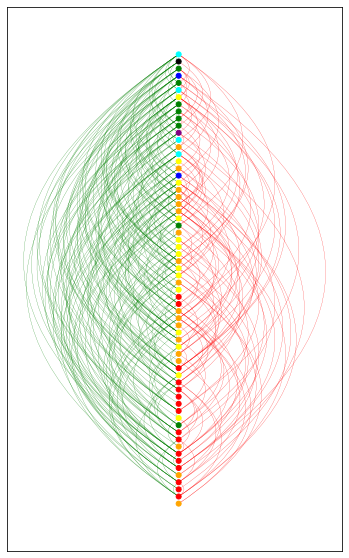

In [208]:
nx.draw_networkx(k, pos = pos, with_labels = False, edge_color = edge_colours,
                node_color = node_colours, node_size = 25, width= 0.2,
                connectionstyle = 'arc3, rad=0.75', arrowstyle = '-')
#plt.savefig('Heirarchy.pdf', bbox_inches='tight')

In [206]:
k.nodes()

NodeView((256, 257, 642, 514, 3, 645, 262, 129, 266, 525, 526, 527, 528, 145, 18, 403, 531, 401, 406, 405, 25, 409, 539, 32, 289, 546, 34, 172, 303, 433, 307, 180, 564, 315, 573, 63, 575, 321, 322, 192, 199, 332, 588, 590, 336, 595, 596, 597, 467, 603, 224, 480, 355, 100, 356, 103, 361, 362, 365, 238, 244, 245, 125, 638))

Kansas 32
Kansas State 64
Wofford 32
St. John's (NY) -1
Alabama -1
Xavier -1
Kentucky 8
Davidson -1
LSU 16
Syracuse 64
TCU -1
Temple -1
Tennessee 16
Duke 8
Arizona State 64
Oklahoma 32
Texas -1
Ohio State 32
Ole Miss 64
Old Dominion 64
Auburn 4
Oregon 16
Texas Tech 2
Baylor 32
Louisville 64
Toledo -1
Belmont 64
Florida 32
Marquette 64
Purdue 8
Maryland 32
Florida State 16
UCF 32
Memphis -1
UNC 16
Buffalo 32
UNC Greensboro -1
Michigan 16
Michigan State 4
Georgetown -1
Gonzaga 8
Minnesota 32
Utah State 64
VCU 64
Mississippi State 64
Villanova 32
Virginia 1
Virginia Tech 16
Saint Mary's 64
Washington 32
Houston 16
Seton Hall 64
Murray State 32
Cincinnati 64
NC State -1
Clemson -1
Nebraska -1
Nevada 64
New Mexico State 64
Indiana -1
Iowa 32
Iowa State 64
Creighton -1
Wisconsin 64
